In [7]:
import seaborn as sns
import json
import pandas as pd
import numpy as np


def load_data(file: str, label: str, other: bool):
    maps = {}
    syms = {}
    has_syms = False
    with open(file) as f:
        for line in f:
            if line.startswith("{"):
                x = json.loads(line)
                if x.get("type") == "map" and x.get("data", {}) is not None:
                    for k, v in x.get("data").items():
                        maps[k] = v
                if x.get("type") == "printf" and (x["data"].startswith("U ") or x["data"].startswith("K ")):
                    raw: str = x["data"].strip()[2:]
                    addr, sym = raw.split("@", 1)
                    syms[int(addr, 16)] = sym
                    has_syms = True
    map = maps["@instr_samples"] if not other else maps["@instr_samples_other"]

    cacheline_count: dict[str, int] = {}
    for k, v in map.items():
        addr = int(k, 16)
        cacheline = f"0x{(addr >> 6) << 6:x}"

        cacheline_count[cacheline] = cacheline_count.get(cacheline, 0) + v

    entries = [(k, v) for k, v in cacheline_count.items()]
    entries.sort(key=lambda x: x[1], reverse=True)
    total_samples = sum(x[1] for x in entries)
    total_instructions = len(map)
    total_cachelines = len(cacheline_count)
    print(f"[{label}] Total samples: {total_samples}, Total instructions: {total_instructions}, Total cachelines: {total_cachelines}")
    entries_w_index = [(float(i + 1) / len(entries), x[0], x[1]) for i, x in enumerate(entries)]
    entries_cumu = []
    s = 0
    for i, x in enumerate(entries_w_index):
        s += x[2]
        entries_cumu.append((x[0], x[1], x[2], s))  # (index, ipaddr, samples, samples.cumulative)
    entries_cumu_norm = [(x[0], x[1], x[2], x[3], x[2] / total_samples, x[3] / total_samples) for x in entries_cumu]
    if has_syms:
        entries_cumu_norm_syms = [(x[0], x[1], x[2], x[3], x[4], x[5], syms.get(int(x[1], 16), "?")) for x in entries_cumu_norm]
        for x in entries_cumu_norm_syms:
            if syms.get(x[1], "?") != "?":
                print(x[1], syms.get(x[1], "?"))
        df = pd.DataFrame(entries_cumu_norm_syms, columns=["cacheline", "cacheline.addr", "samples", "samples.cumu", "samples.norm", "samples.cumu.norm", "symbol"])
    else:
        df = pd.DataFrame(entries_cumu_norm, columns=["cacheline", "cacheline.addr", "samples", "samples.cumu", "samples.norm", "samples.cumu.norm"])
    # print(df)
    return df


def plot(**files: str):
    dfs = []
    for k, v in files.items():
        if k.endswith("other"):
            df = load_data(v, label=k, other=True)
        else:
            df = load_data(v, label=k, other=False)
        df["gc"] = k
        dfs.append(df)
    df = pd.concat(dfs)

    g = sns.lineplot(data=df, x="cacheline", y="samples.cumu.norm", hue="gc")

    if g.axes:
        g.axes.grid(True, axis="both")

    g.set_xticks(np.arange(0, 1.1, 0.1))
    g.set_yticks(np.arange(0, 1.1, 0.1))

    return df

# Luseach (No CompressedOops, 512M heap)

[ix] Total samples: 865730, Total instructions: 8041, Total cachelines: 2397
[lxr] Total samples: 326990, Total instructions: 9073, Total cachelines: 2947
[g1] Total samples: 322744, Total instructions: 7796, Total cachelines: 2317
[shen] Total samples: 925520, Total instructions: 7257, Total cachelines: 1927
[z] Total samples: 2460228, Total instructions: 8282, Total cachelines: 2355
[par] Total samples: 689247, Total instructions: 6696, Total cachelines: 1632
[other] Total samples: 18062196, Total instructions: 204254, Total cachelines: 61789


,cacheline,cacheline.addr,samples,samples.cumu,samples.norm,samples.cumu.norm,gc
0,0.000417,0x7d15793fc1c0,87493,87493,1.010627e-01,0.101063,ix
1,0.000834,0x7d1579da1b40,62393,149886,7.206981e-02,0.173133,ix
2,0.001252,0x7d157815f880,55462,205348,6.406385e-02,0.237196,ix
3,0.001669,0x7d1579057740,52673,258021,6.084229e-02,0.298039,ix
4,0.002086,0x7d1578166ac0,33149,291170,3.829023e-02,0.336329,ix
...,...,...,...,...,...,...,...
61784,0.999935,0x7729e1158700,1,18062192,5.536425e-08,1.000000,other
61785,0.999951,0x772a006f4480,1,18062193,5.536425e-08,1.000000,other
61786,0.999968,0x7729e1232d80,1,18062194,5.536425e-08,1.000000,other
61787,0.999984,0xffffffff95415b80,1,18062195,5.536425e-08,1.000000,other


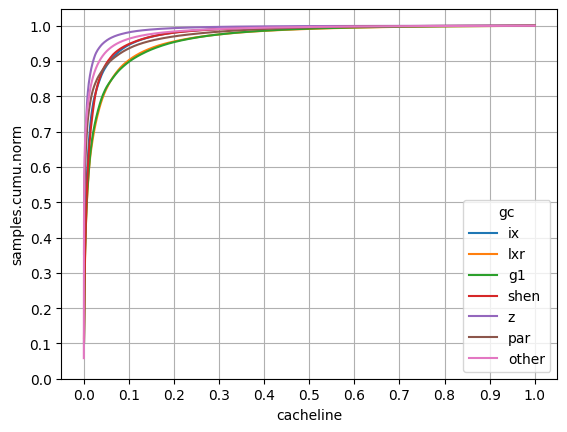

In [8]:
plot(
    ix="../../lusearch-ix.jsonl",
    lxr="../../lusearch-lxr.jsonl",
    g1="../../lusearch-g1.jsonl",
    shen="../../lusearch-shen.jsonl",
    z="../../lusearch-z.jsonl",
    par="../../lusearch-par.jsonl",
    other="../../lusearch-g1.jsonl",
)

# H2 (No CompressedOops, 1G heap)

[ix] Total samples: 21143168, Total instructions: 12298, Total cachelines: 3372
[lxr] Total samples: 3590639, Total instructions: 11136, Total cachelines: 3100
[g1] Total samples: 10235384, Total instructions: 15573, Total cachelines: 3545
[shen] Total samples: 33385677, Total instructions: 8772, Total cachelines: 2272
[z] Total samples: 45932321, Total instructions: 10095, Total cachelines: 2734
[par] Total samples: 10019001, Total instructions: 7709, Total cachelines: 1755
[other] Total samples: 25040341, Total instructions: 243862, Total cachelines: 65946


,cacheline,cacheline.addr,samples,samples.cumu,samples.norm,samples.cumu.norm,gc
0,0.000297,0x76822af66ac0,3626678,3626678,1.715295e-01,0.171530,ix
1,0.000593,0x76822af5a3c0,2785326,6412004,1.317365e-01,0.303266,ix
2,0.000890,0x76822af82a00,2096759,8508763,9.916958e-02,0.402436,ix
3,0.001186,0x76822af5a400,1983545,10492308,9.381494e-02,0.496251,ix
4,0.001483,0x76822af77b00,1697293,12189601,8.027619e-02,0.576527,ix
...,...,...,...,...,...,...,...
65941,0.999939,0x7889854eee00,1,25040337,3.993556e-08,1.000000,other
65942,0.999955,0x7889a48792c0,1,25040338,3.993556e-08,1.000000,other
65943,0.999970,0x78898c20d500,1,25040339,3.993556e-08,1.000000,other
65944,0.999985,0x78898c36afc0,1,25040340,3.993556e-08,1.000000,other


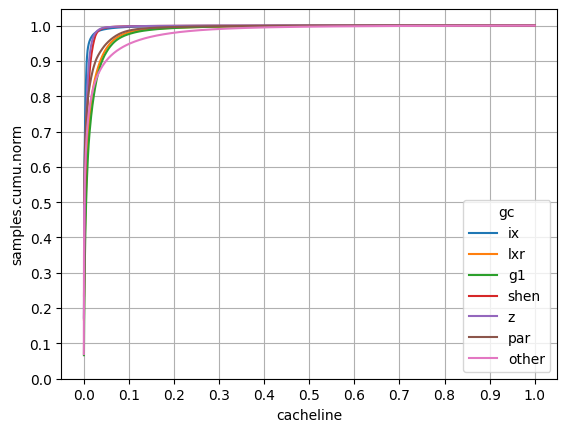

In [9]:
plot(
    ix="../../h2-ix.jsonl",
    lxr="../../h2-lxr.jsonl",
    g1="../../h2-g1.jsonl",
    shen="../../h2-shen.jsonl",
    z="../../h2-z.jsonl",
    par="../../h2-par.jsonl",
    other="../../h2-g1.jsonl",
)

# Kafka (No CompressedOops, 512M heap)

[ix] Total samples: 357414, Total instructions: 5553, Total cachelines: 1925
[lxr] Total samples: 115293, Total instructions: 6297, Total cachelines: 2297
[g1] Total samples: 206437, Total instructions: 8226, Total cachelines: 2486
[shen] Total samples: 396836, Total instructions: 6028, Total cachelines: 1786
[z] Total samples: 2067530, Total instructions: 6795, Total cachelines: 1892
[par] Total samples: 523144, Total instructions: 5392, Total cachelines: 1607
[other] Total samples: 2778605, Total instructions: 201032, Total cachelines: 73793


,cacheline,cacheline.addr,samples,samples.cumu,samples.norm,samples.cumu.norm,gc
0,0.000519,0x786add439bc0,35429,35429,9.912594e-02,0.099126,ix
1,0.001039,0x786adce57740,28910,64339,8.088659e-02,0.180013,ix
2,0.001558,0x786add1fc1c0,26355,90694,7.373802e-02,0.253751,ix
3,0.002078,0x786adbf66ac0,24661,115355,6.899842e-02,0.322749,ix
4,0.002597,0x786adbf5a400,14182,129537,3.967948e-02,0.362428,ix
...,...,...,...,...,...,...,...
73788,0.999946,0x72721d5bca80,1,2778601,3.598928e-07,0.999999,other
73789,0.999959,0x72723abe3800,1,2778602,3.598928e-07,0.999999,other
73790,0.999973,0x72723aaee700,1,2778603,3.598928e-07,0.999999,other
73791,0.999986,0x72721cff9a80,1,2778604,3.598928e-07,1.000000,other


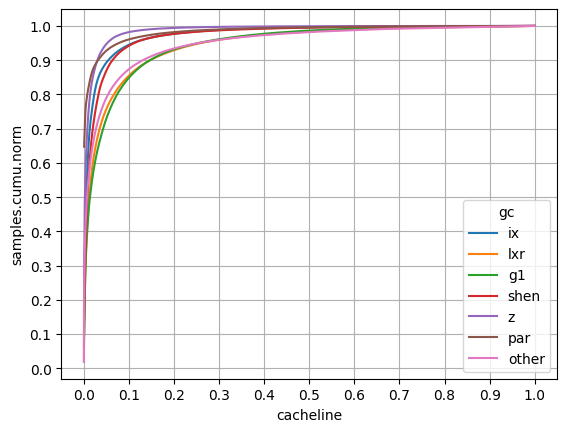

In [10]:
plot(
    ix="../../kafka-ix.jsonl",
    lxr="../../kafka-lxr.jsonl",
    g1="../../kafka-g1.jsonl",
    shen="../../kafka-shen.jsonl",
    z="../../kafka-z.jsonl",
    par="../../kafka-par.jsonl",
    other="../../kafka-g1.jsonl",
)